In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.linalg import kron, eigvalsh



This script builds the full AKLT Hamiltonian via tensor product $\texttt{np.kron()}$ and studies some physical properties of the Hamiltonian 

In [2]:
class AKLT_Exact():
    """Handles Hamiltonian construction and basic diagonalization for small N."""
    
    def __init__(self, N, boundary_open=True):
        """
        Initialize AKLT chain with specified boundary conditions.
        
        Args:
            N (int): Number of spins in the chain
            boundary_open (bool): True for open boundaries, False for periodic
        """
        self.N = N
        self.d = 3  
        self._initialize_spin_operators()
        self.H = self.Hamiltonian(boundary_open=boundary_open)
        self.bond_dim = 2
        
    def _initialize_spin_operators(self):
        """Initialize spin-1 operators Sx, Sy, Sz with proper normalization."""
        # Spin-1 operators in the z-basis (dimension 3x3)
        self.X = np.sqrt(1/2) * np.array([[0, 1, 0],
                                         [1, 0, 1], 
                                         [0, 1, 0]], dtype=np.complex128)
        
        self.Y = (-1j * np.sqrt(1/2) * np.array([[0, 1, 0],
                                                [-1, 0, 1],
                                                [0, -1, 0]], dtype=np.complex128))
        
        self.Z = np.array([[1, 0, 0],
                   [0, 0, 0],
                   [0, 0, -1]], dtype=np.complex128)

    def construct_chain(self, operator1, operator2, i, j):
        """
        Embed a two-site operator into the full N-spin Hilbert space.

        Args:
            operator1: 3x3 matrix for site i
            operator2: 3x3 matrix for site j
            i, j (int): Target positions in the chain (0-based)

        Returns:
            A 3^N x 3^N matrix with operators embedded at i and j
        """
        # Initialize chain with identity matrices
        a_chain = [np.eye(self.d, dtype=np.complex128) for _ in range(self.N)]
        
        # Place operators at specified positions
        a_chain[i] = operator1
        a_chain[j] = operator2
        
        # Build full operator via Kronecker product
        result = a_chain[0]
        for ii in range(1, self.N):
            result = np.kron(result, a_chain[ii])
        return result

    def scalar_product(self, i, boundary_open):
        """
        Compute S_i · S_{i+1} interaction term.
        
        Args:
            i: Site index
            boundary_open: Whether to use open boundary conditions
            
        Returns:
            The interaction term S_i·S_j where j = i+1 (with boundary handling)
        """
        if boundary_open == True:
            j = i + 1
            result = (
                self.construct_chain(self.X, self.X, i, j) +
                self.construct_chain(self.Y, self.Y, i, j)+
                self.construct_chain(self.Z, self.Z, i, j)
            )
        else: 
            j = (i + 1) % self.N
            result = (
                self.construct_chain(self.X, self.X, i, j) +
                self.construct_chain(self.Y, self.Y, i, j) +
                self.construct_chain(self.Z, self.Z, i, j)
            )



        return result
    


    def Hamiltonian(self, boundary_open):
        """
        Construct full AKLT Hamiltonian.
        
        Args:
            boundary_open: Boundary condition flag
            
        Returns:
            The Hamiltonian matrix H = Σ_i [S_i·S_{i+1} + (1/3)(S_i·S_{i+1})²]
        """
        H = np.zeros((self.d**self.N, self.d**self.N), dtype=np.complex128)


        if boundary_open ==True:
            for ii in range(self.N - 1):  # Loop over neighboring pairs
                SdotS = self.scalar_product(ii, boundary_open)
                H += SdotS + (1/3)*(SdotS @ SdotS)
        else:

            for ii in range(self.N):  # Loop over neighboring pairs
                SdotS = self.scalar_product(ii, boundary_open)
                H += SdotS + (1/3)*(SdotS @ SdotS)


        return H

    
    
    def ground_and_excited_states(self, ):
        """
        Diagonalize Hamiltonian to get energy spectrum.
        
        Returns:
            eigenvalues: Array of energy eigenvalues
            eigenvectors: Corresponding eigenstates
        """
        eigenvalues, eigenvectors = np.linalg.eigh(self.H)
        return eigenvalues, eigenvectors
    
    
    def total_spin_analysis_full_space(self, eigenvalues, eigenvectors):
        """
        Analyze total spin properties for ALL eigenstates of the Hamiltonian.

        Args:
            N (int): Number of sites.
            H (np.ndarray): Full Hamiltonian matrix.
            eigenvalues (np.ndarray): Eigenvalues of H.
            eigenvectors (np.ndarray): Eigenvectors of H (columns).

        Returns:
            tuple: (S_z_values, S_squared_values, energies) for all eigenstates.
        """
        # Initialize total spin operators (Sx, Sy, Sz)
        S_T = np.zeros((self.d**self.N, self.d**self.N, 3), dtype=np.complex128)


        # Build total spin operators Sx, Sy, Sz
        for j, op in enumerate([self.X, self.Y, self.Z]):
            S_Tj = np.zeros((self.d**self.N, self.d**self.N), dtype=np.complex128)
            for l in range(self.N):
                op_chain = [np.eye(self.d)] * self.N
                op_chain[l] = op
                S_l = op_chain[0]
                for i in range(1, self.N):
                    S_l = np.kron(S_l, op_chain[i])
                S_Tj += S_l
            S_T[:, :, j] = S_Tj

        # Total spin squared operator (S^2 = Sx^2 + Sy^2 + Sz^2)
        S_Tsq = sum(S_T[:, :, j] @ S_T[:, :, j] for j in range(3))
        S_Tsq = 0.5 * (S_Tsq + S_Tsq.conj().T)  # Ensure Hermiticity

        # Sz operator (already Hermitian)
        S_Tz = S_T[:, :, 2]

        # Compute expectation values for all eigenstates
        num_states = eigenvectors.shape[1]
        S_z_values = np.zeros(num_states)
        S_squared_values = np.zeros(num_states)

        for s in range(num_states):
            state = eigenvectors[:, s]
            S_z_values[s] = np.real(state.conj().T @ S_Tz @ state)
            S_squared_values[s] = np.real(state.conj().T @ S_Tsq @ state)

        return S_z_values, S_squared_values, eigenvalues
    
    #Implementation of the MPS decomposition

    def split(self, M):
        """
        Split a matrix M via SVD and truncate to at most `bond_dim` singular values.

        The input M is expected to be reshaped as a bipartition of a wavefunction.
        The output is reshaped U, S, V matrices used for constructing the MPS tensors.
        """
        
        U, S, Vd = np.linalg.svd(M, full_matrices=False)
        bonds = len(S)
        

        # Reshape for MPS construction
        Vd = Vd.reshape(bonds, self.d, -1)
        U = U.reshape((-1, self.d, bonds))
       

        chi = np.min([bonds, self.bond_dim])
        U, S, Vd = U[:, :, :chi], S[:chi], Vd[:chi]
        return U, S, Vd

    def statevector_to_mps(self, psi):
        """
        Decompose a full quantum state vector into a left-canonical MPS using SVD.

        Parameters:
            psi: The full statevector of the system (shape 3^N).

        Returns:
            Ms: List of MPS tensors (one per site).
            Ss: List of singular value vectors (entanglement spectrum across each bond).
        """
        Ms = []
        Ss = []

        # First split
        psi = np.reshape(psi, (self.d, -1))
        U, S, Vd = self.split(psi)
        Ms.append(U)
        Ss.append(S)
        bondL = Vd.shape[0]
        
        psi = np.tensordot(np.diag(S), Vd, 1)

        # Recursively SVD the remaining sites
        for _ in range(self.N-2):
            psi = np.reshape(psi, (self.d*bondL, -1))
            U, S, Vd = self.split(psi)
            Ms.append(U)
            Ss.append(S)
            psi = np.tensordot(np.diag(S), Vd, 1)
            bondL = Vd.shape[0]

        # Final dummy site
        psi = np.reshape(psi, (-1, 1))
        U, _, _ = np.linalg.svd(psi, full_matrices=False)
        U = np.reshape(U, (-1, self.d, 1))
        Ms.append(U)

        Ms = [np.asarray(tensor) for tensor in Ms]
        Ss = [np.asarray(s) for s in Ss]

        return Ms, Ss
    

    def entanglement_entropy(self, singular_values, eps=0.02):
        """
        Compute von Neumann entropy from singular values of each bond.

        Parameters:
            singular_values: list of arrays of singular values
            eps: numerical cutoff to avoid log(0) issues

        Returns:
            List of entropies across bonds
        """
        entropies = []
        for vec in singular_values:
            s = np.asarray(vec)
            s_sq = s**2
            s_sq = s_sq / np.sum(s_sq)
            s_sq = s_sq[s_sq > eps]  # avoid numerical log(0)
            if len(s_sq) == 0:
                entropy = 0.0
            else:
                entropy = -np.sum(s_sq * np.log(s_sq))
            entropies.append(entropy)
            if len(s_sq) < 2:
                print("CHECK!!!!!!!!!!!!!!!!!!!!!!!!!!")
        return entropies      
    
    
    def check_left_isometry(Ms):
        """
        Check if MPS is in left-canonical form by verifying:
        For each tensor (except last), U†U = I

        Returns:
            List of tuples (site index, isometry status)
        """
        results = []
        for i, tensor in enumerate(Ms[:-1]):
            chiL, d, chiR = tensor.shape
            print(tensor.shape)
            U = tensor.reshape(-1, chiR)
            is_iso = np.allclose(U.conj().T @ U, np.eye(chiR), atol=1e-10)
            results.append((i, is_iso))
        return results
    
    def correlation_lenght(self, ground_state):
        """Calculate the connected spin-spin correlation function C(r) = <S_z(i_ref) S_z(j)> - <S_z(i_ref)><S_z(j)>
        for sites j to the right of the reference site i_ref in the chain."""
        # Choose the reference site to be the middle of the chain
        i_ref = self.N // 2
        print(i_ref)
        
        I = np.eye(self.d, dtype=np.complex128)

        C = []
        
        distances = []
        
        for r in range(1, self.N-i_ref):
            j = i_ref+r
            op_single_szi = self.construct_chain(self.Z, I, i_ref, j)
            op_single_szj = self.construct_chain(I, self.Z, i_ref, j)
            Sz_iSz_j = self.construct_chain(self.Z, self.Z, i_ref, j)
            
            # Compute expectation values
            exp_val_szi = np.real(ground_state.conj()@op_single_szi@ ground_state)
            exp_val_szj = np.real(ground_state.conj()@op_single_szj@ ground_state)
            exp_val_sziszj = np.real(ground_state.conj()@Sz_iSz_j@ ground_state)
            
             # Compute connected correlation function C_ij = <S^z_i S^z_j> - <S^z_i><S^z_j>
            Cij = exp_val_sziszj - exp_val_szi*exp_val_szj
            
            
            distances.append(r)
            
            C.append(Cij)
            
        return np.array(distances), np.array(C)
    


### Boundary conditions

Open and closed boundary conditions: The AKLT Hamiltonian shows some differences in the energy spectrum due to boundary effects

For open boundary conditions (OBC) we see the ground state is 4 degenerate. Each spin-1 is decomposed into two spin-1/2 particles for OBC the spin-1/2 at the chain ends are unpaired each unpaired spin at the edges can be in $$|\uparrow\rangle$$ or $$|\downarrow\rangle$$ 
So there is a four fold degeneracy, $|\uparrow\rangle|\downarrow\rangle$, $|\downarrow\rangle|\uparrow\rangle$, $|\uparrow\rangle|\uparrow\rangle$ and $|\downarrow\rangle|\downarrow\rangle$

For periodic boundary conditions (PBC) the cain has no edges since all spin-1/2 are paired so the ground state is unique

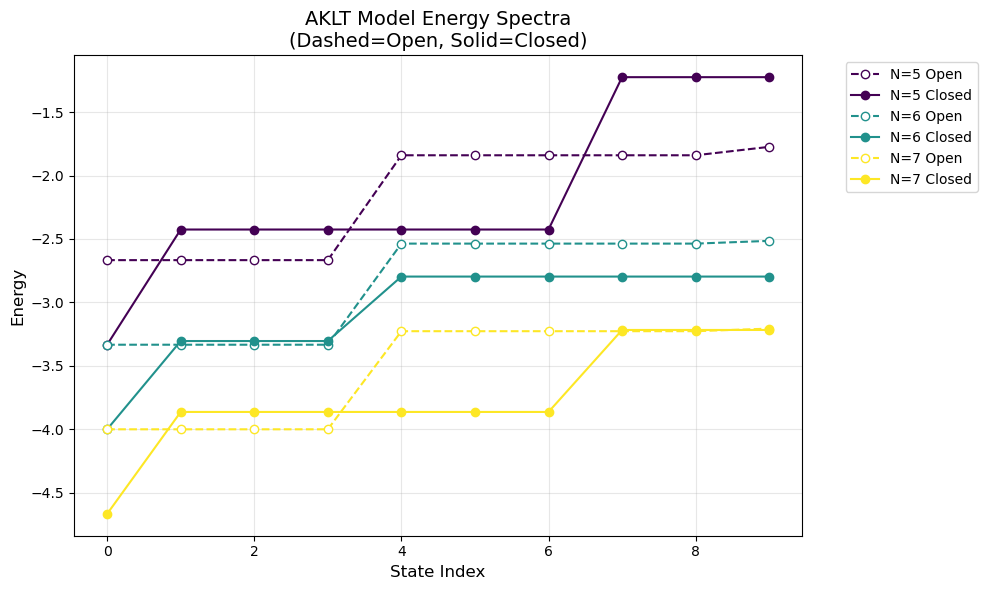

In [3]:
"""Open and closed boundary conditions"""
ns = [5, 6, 7]
colors = plt.cm.viridis(np.linspace(0, 1, len(ns)))  # Color gradient for different N values

plt.figure(figsize=(10, 6))

for i, nn in enumerate(ns):
    # Open boundary (dashed line with circles)
    aklt_open = AKLT_Exact(nn, boundary_open=True)
    eigenvalues_open, _ = aklt_open.ground_and_excited_states()
    plt.plot(eigenvalues_open[:10], '--o', color=colors[i], 
             markersize=6, markeredgecolor=colors[i], markerfacecolor='white',
             label=f'N={nn} Open')
    
    # Closed boundary (solid line with filled circles)
    aklt_closed = AKLT_Exact(nn, boundary_open=False)
    eigenvalues_closed, _ = aklt_closed.ground_and_excited_states()
    plt.plot(eigenvalues_closed[:10], '-o', color=colors[i], 
             markersize=6, markerfacecolor=colors[i],
             label=f'N={nn} Closed')

plt.xlabel('State Index', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title('AKLT Model Energy Spectra\n(Dashed=Open, Solid=Closed)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



###  Energy spectrum and symmetries

The AKLT Hamiltonian commutes with the $S^z_\text{tot}=\sum_i S^z_i$ and $\mathbf{S}^2\equiv(\sum\;\vec{S}^i)^2$ where the operator $\vec{S}^i$ is defined as the collection of operators $(S^i_x, S^i_y, S^i_z)$. This leads to the decomposition of the Hilbert space into spin sectors which allows us to classify the eigenstates according to the spin operstors $S^z_\text{tot}$ and $\mathbf{S}^2$

The total squared spin operator is $\mathbf{S}^2\equiv(\sum\;\vec{S}^i)^2$ with eigenvalues given by $l(l+1)$ in the code S_T = np.zeros((3N, 3N, 3), dtype=np.complex128) creates a 3D array to store the three components (Sx, Sy, Sz) each component is a $3^N\times 3^N$ matrix

For each spin component (X, Y, Z)

- creates a local operator at each site l
- builds the full operator via Kronecker products
- sums over all sites to get the spin operator

Then computes $S^2= S_x^2+S^2_y+S^2_z$

Finally compute the expectation values $\langle \psi|S_z|\psi\rangle$ and $\langle \psi|S^2|\psi\rangle$

where $\psi$ are the eigenvectors found diagonalizing the full Hamiltonian matrix

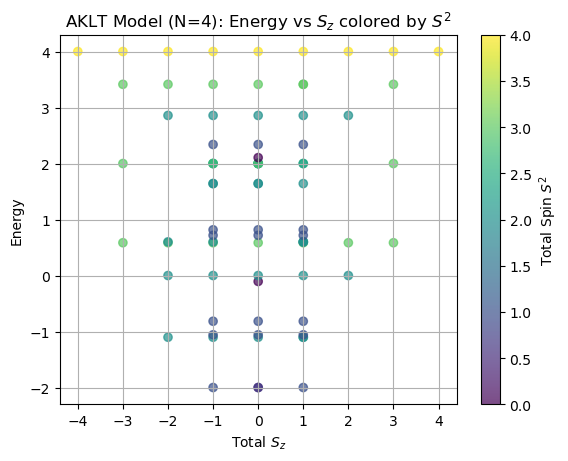

In [ ]:
Ns= [4, 8]
for N in Ns:
    
    aklt = AKLT_Exact(N, boundary_open=True)
    eigenvalues, eigenvectors = aklt.ground_and_excited_states()
    
    S_z_values, S_squared_values, energies = aklt.total_spin_analysis_full_space(eigenvalues, eigenvectors)
    S_z_rounded = np.round(S_z_values)
    
    # Compute total spin S from S^2: S = (sqrt(4*S_squared + 1) - 1)/2
    S_values = (np.sqrt(4 * S_squared_values + 1) - 1) / 2
    
    # Plot with color-coding by S
    plt.scatter(S_z_rounded, energies, c=S_values, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Total Spin $S^2$')
    plt.xlabel('Total $S_z$')
    plt.ylabel('Energy')
    plt.title(f'AKLT Model (N={N}): Energy vs $S_z$ colored by $S^2$')
    plt.grid()
    plt.show()

    


### Entropy

We construct the ground state of the AKLT model (spin-1 chain) 
and represents it as a Matrix Product State (MPS). 
It then computes the entanglement entropy (Von Neumann entropy) across every bond in the chain
for several chain lengths N.

Von Neumann entropy $$S=-\sum_i\tilde{s}^2_i\log\tilde{s}^2_i$$ 
with $$\tilde{s}^2_i=\frac{s^2_i}{\sum_j s^2_j}$$ where $$s_i$$ are the singular values found doing the SVD


In [3]:

N_values = [2, 3, 4, 5, 6, 7, 8]  # Chain lengths to simulate


degeneracy = 4    # number of ground states expected from AKLT model
entropy_profiles = {}

# Loop over different chain lengths
for N in N_values:
    aklt = AKLT_Exact(N, boundary_open=True)
    eigenvalues, eigenvectors = aklt.ground_and_excited_states()
    
    # Extract degenerate ground space
    ground_states = eigenvectors[:, :degeneracy]
    state = ground_states[:, 0]
    state = state/np.linalg.norm(state)

    # Convert statevector to MPS
    mps_vectors, mps_svalues = aklt.statevector_to_mps(state)
    
    # Compute entanglement entropy across all internal bonds
    entropies = aklt.entanglement_entropy(mps_svalues)

    entropy_profiles[N] = entropies


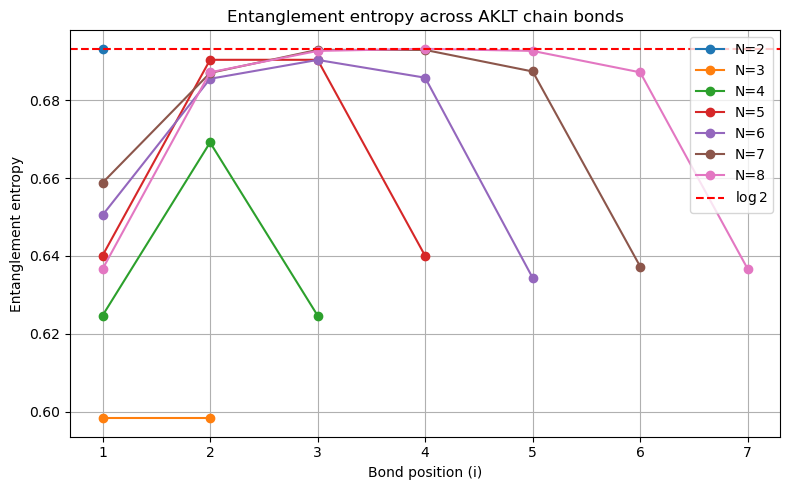

In [4]:
plt.figure(figsize=(8, 5))
for N, entropies in entropy_profiles.items():
    plt.plot(range(1, N), entropies, marker='o', label=f'N={N}')

log2 = np.log(2)
plt.axhline(y=log2, color='r', linestyle='--', label=r'$\log 2$')

plt.xlabel("Bond position (i)")
plt.ylabel("Entanglement entropy")
plt.title("Entanglement entropy across AKLT chain bonds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Correlation lenght

We tried implementing the correlation length via the correlation function but the system is too small to get something accurate

In [23]:
Ns= [8]
for N in Ns:
    
    aklt = AKLT_Exact(N, boundary_open=True)
    eigenvalues, eigenvectors = aklt.ground_and_excited_states()  

In [24]:
psi0 = eigenvectors[:, 0]          # ground state from ED (normalised)
distances, correlations = aklt.correlation_length(psi0)
print(distances)

[1 2 3]


In [25]:
log_corr = np.log(abs(correlations))
slope, intercept, r_value, p_value, std_err = stats.linregress(distances, log_corr)

xi = -1/slope
print(f"Fitted correlation length ξ = {xi:.3f}")

Fitted correlation length ξ = 0.833


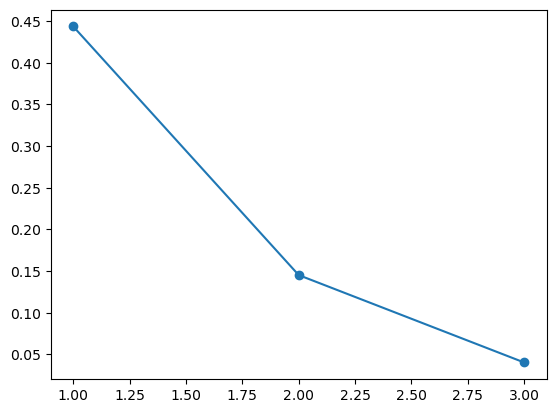

In [26]:
plt.plot(distances, abs(correlations), marker = "o")